In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [3]:
from mkl_fft import fftn, ifftn
import cupy as cp
import cupyx.scipy.fft as cufft
import scipy.fft
import cupyx.scipy.ndimage as cuimage

In [4]:
# Create the job
job = Job('/mnt/md0/runs','AH007_2022-03-28_2-4-5', create=False, overwrite=False, verbosity = 10)
tifs, si_params, exp_str = flu.find_exp(job.params['subjects_dir'], job.params['subject'],
                                        job.params['date'], job.params['expnum'])

exp_dir = flu.find_expt_file((job.params['subject'], job.params['date'], job.params['expnum'][0]),
                         'root', dirs=[job.params['subjects_dir']])
offset_files = job.get_registered_files('registered_data', 'offset')

   Found and loaded params from /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/params.npy
SI ROI pix count in x is 182, which is impossible, setting it to 145


In [5]:
cz = (0,25)
ct = (0, 10)
cy = (None,None)
cx = (None,None)

In [6]:
offsets = [n.load(f,allow_pickle=True).item() for f in offset_files]
offset = offsets[0]
for k,v in offset.items():
    offset[k] = n.array(n.concatenate([o[k] for o in offsets],axis=1) )
    offset[k] = offset[k][cz[0]:cz[1], ct[0]:ct[1]]
dx = (offset['xms'] - n.floor(offset['xms'].mean(axis=1,keepdims=True)))[cz[0]:cz[1]]
dy = (offset['yms'] - n.floor(offset['yms'].mean(axis=1,keepdims=True)))[cz[0]:cz[1]]

In [7]:
summary = job.load_summary()
all_ops = summary['all_ops']
crosstalk_coeff = summary['crosstalk_coeff']
refs_and_masks = summary['refs_and_masks']
ref_img = summary['ref_img_3d'][cz[0]:cz[1]]
min_pix_vals = summary['min_pix_vals']
mask_mul, mask_offset, ref_2ds = n.stack([r[:3] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]
mask_mul_nr, mask_offset_nr, ref_nr = n.stack([r[3:] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]
rmins = n.array([op['rmin'] for op in all_ops])
rmaxs = n.array([op['rmax'] for op in all_ops])

ops = all_ops[0]
snr_thresh = ops['snr_thresh']
NRsm = ops['NRsm'].astype(n.float32)
yblocks, xblocks = ops['yblock'], ops['xblock']
max_shift = 5
subpixel = 10
n_smooth_iters = 2
npad = 3

In [8]:
mov_raw = lbmio.load_and_stitch_tifs(job.tifs[:1], planes = n.arange(cz[0],cz[1]))[:,:,cy[0]:cy[1], cx[0]:cx[1]]
mov_raw = mov_raw[:,ct[0]:ct[1]]
mov_pos = mov_raw - min_pix_vals.reshape(len(min_pix_vals), 1, 1, 1)[cz[0]:cz[1],]

Loading /mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00001_00001.tif
Loaded 1 files, total 1.48 GB


In [9]:
from suite3d import register_gpu as rgpu 
from suite2p.registration import nonrigid as s2pnr
from suite2p.registration import rigid as s2prr

In [17]:
mempool = cp.get_default_memory_pool()

In [10]:
%%time
mov_shifted, ymaxs, xmaxs = rgpu.rigid_2d_reg_gpu(mov_pos, mask_mul, mask_offset, ref_2ds, shift=True,
                                                 max_reg_xy = 50, rmins=rmins, rmaxs=rmaxs, crosstalk_coeff=crosstalk_coeff)
# mov_shifted_gpu = mov_shifted.get()
ymaxs_rr_gpu = ymaxs.get(); 
xmaxs_rr_gpu = xmaxs.get()

Loaded mov and masks to GPU for rigid reg in 2.21 sec
Subtracting crosstalk
Allocating memory for shifted movie
GPU RAM: 1 blocks allocated, 4.09 / 4.18 GB used
Registering plane 0
Shifting plane 0
Registering plane 1
Shifting plane 1
Registering plane 2
Shifting plane 2
Registering plane 3
Shifting plane 3
Registering plane 4
Shifting plane 4
Registering plane 5
Shifting plane 5
Registering plane 6
Shifting plane 6
Registering plane 7
Shifting plane 7
Registering plane 8
Shifting plane 8
Registering plane 9
Shifting plane 9
Registering plane 10
Shifting plane 10
Registering plane 11
Shifting plane 11
Registering plane 12
Shifting plane 12
Registering plane 13
Shifting plane 13
Registering plane 14
Shifting plane 14
Registering plane 15
Shifting plane 15
Registering plane 16
Shifting plane 16
Registering plane 17
Shifting plane 17
Registering plane 18
Shifting plane 18
Registering plane 19
Shifting plane 19
Registering plane 20
Shifting plane 20
Registering plane 21
Shifting plane 21
R

In [20]:
%%time
ymaxs, xmaxs, snrs = rgpu.nonrigid_2d_reg_gpu(mov_shifted, mask_mul_nr[:,:,0], mask_offset_nr[:,:,0], ref_nr[:,:,0], 
                                              yblocks, xblocks, snr_thresh, NRsm, rmins, rmaxs, max_shift=max_shift, 
                                              npad=npad, n_smooth_iters=n_smooth_iters, subpixel = subpixel)
ymaxs_nr_gpu = ymaxs.get()
xmaxs_nr_gpu = xmaxs.get()
mempool.free_all_blocks()

Allocated GPU array for non-rigid reg in 0.19 sec
Blocked movie is 5.49GB
GPU RAM: 7 blocks allocated, 8.28 / 8.60 GB used
Clipped movie in 0.00 sec
Split movie into blocks in 0.00 sec
Completed FFT of blocks and computed phase correlations in 0.01 sec
Iter 0: 22035/45000 blocks below SNR thresh
Iter 1: 12454/45000 blocks below SNR thresh
Iter 1: 9228/45000 blocks below SNR thresh
Computed SNR and smoothed phase corrs in 0.29 sec
Computed subpixel shifts in 0.03 sec
GPU RAM: 9 blocks allocated, 8.38 / 8.60 GB used
CPU times: user 1.24 s, sys: 2.78 s, total: 4.02 s
Wall time: 539 ms


In [24]:
nt, nz, ny, nx = mov_shifted.shape
nblocks = ops['nblocks']

In [56]:
zidx = 5
ymax1 = ymaxs_nr_gpu[:,zidx]
xmax1 = xmaxs_nr_gpu[:,zidx]

In [64]:
xmax1.shape

(10, 180)

In [57]:
yup, xup = s2pnr.upsample_block_shifts(nx, ny, nblocks, xblock=xblocks, yblock=yblocks, 
                                       ymax1=ymax1, xmax1=xmax1)

In [58]:
yblock = cp.asarray(yblocks).reshape(*nblocks,2)
xblock = cp.asarray(xblocks).reshape(*nblocks,2)

In [59]:
yc = yblock[:,0].mean(axis=1)
xc = xblock[0].mean(axis=1)

In [62]:
from cupyx.scipy.interpolate import RegularGridInterpolator

In [66]:
%%time
xups = []; yups = []
for zidx in range(nz):
    yup, xup = s2pnr.upsample_block_shifts(nx, ny, nblocks, xblock=xblocks, yblock=yblocks, 
                                           ymax1=ymaxs_nr_gpu[:,zidx], xmax1=xmaxs_nr_gpu[:,zidx])
    xups.append(xup)
    yups.append(yup)
xups = n.stack(xups,axis=1); yups = n.stack(yups,axis=1)

xups_abs = cp.asarray(xups) + cp.arange(nx,dtype=cp.float32)[cp.newaxis, cp.newaxis, cp.newaxis]
yups_abs = cp.asarray(yups) + cp.arange(ny,dtype=cp.float32)[cp.newaxis, cp.newaxis,:, cp.newaxis]
tt = cp.arange(nt); zz = cp.arange(nz); yy = cp.arange(ny); xx = cp.arange(nx)

data = mov_shifted.copy()
coords = cp.zeros((nz, ny, nx, 3), dtype=cp.float32)
for tidx in range(nt):
    coords[:,:,:,0] = cp.arange(nz)[:, cp.newaxis, cp.newaxis]
    coords[:,:,:,1] = yups_abs[tidx]
    coords[:,:,:,2] = xups_abs[tidx]
    interp = RegularGridInterpolator((zz,yy,xx), data[tidx], bounds_error=False, fill_value=None)
    data[tidx] = interp(coords,method='linear')

CPU times: user 6.68 s, sys: 1.07 s, total: 7.74 s
Wall time: 2.89 s


In [67]:
mov_trf_gpu = data.get()

In [71]:
mov_cpu = mov_shifted.get()

In [72]:
%%time
mov_trf_cpu = n.zeros_like(mov_cpu)
for zidx in range(25):
    mov_trf_cpu[:,zidx] = s2pnr.transform_data(mov_cpu[:,zidx], nblocks, xblock=xblocks, yblock=yblocks, 
                                       ymax1=ymaxs_nr_gpu[:,zidx], xmax1=xmaxs_nr_gpu[:,zidx])

CPU times: user 8.66 s, sys: 1.11 s, total: 9.77 s
Wall time: 1.69 s


In [73]:
notclose = ~n.isclose(mov_trf_cpu, mov_trf_gpu, 1e-3, 1e-5)

In [74]:
(notclose).sum() / mov_trf_gpu.size

0.0019411162020606051

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7efd9a9c2b80>)

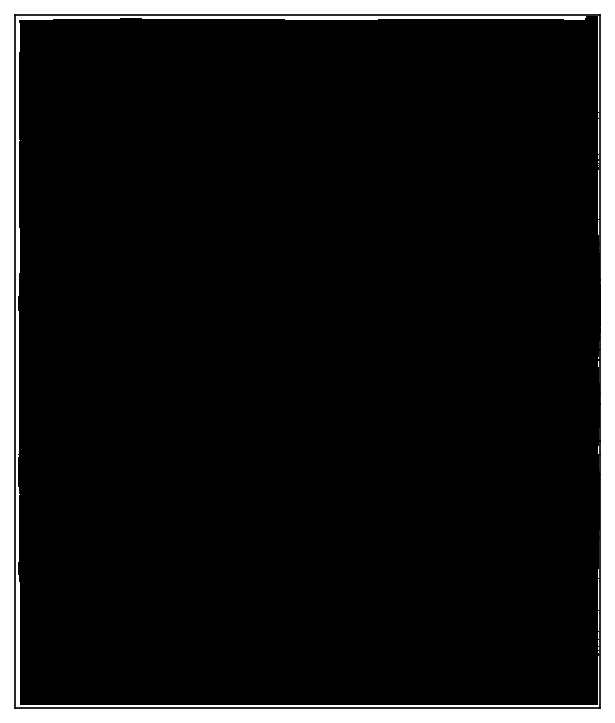

In [75]:
tfu.show_tif(notclose.astype(int).sum(axis=(0,1)),vminmax=(0,1))# vminmax=(0,10))

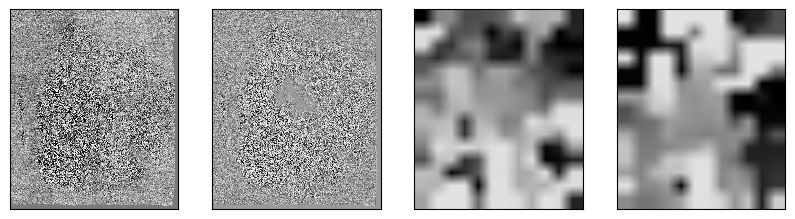

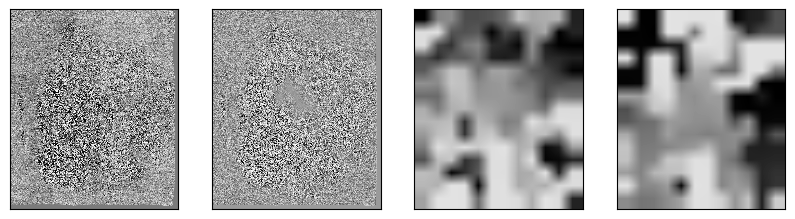

In [79]:
idx = (5,24)
vx_coord = (-8,8)
f,axs = plt.subplots(1,4, figsize=(10,6))
tfu.show_tif(mov_trf_gpu[idx],ax=axs[0])
tfu.show_tif(mov_trf_gpu[idx] - mov_cpu[idx],ax=axs[1])
tfu.show_tif(yups[idx],ax=axs[2], vminmax=vx_coord)
tfu.show_tif(xups[idx],ax=axs[3], vminmax=vx_coord)
plt.show()

f,axs = plt.subplots(1,4, figsize=(10,6))
tfu.show_tif(mov_trf_cpu[idx],ax=axs[0])
tfu.show_tif(mov_trf_cpu[idx] - mov_cpu[idx],ax=axs[1])
tfu.show_tif(yups[idx],ax=axs[2], vminmax=vx_coord)
tfu.show_tif(xups[idx],ax=axs[3], vminmax=vx_coord)
plt.show()


In [236]:
%%time
mov_trf_cpu = n.zeros_like(mov_trf_cpu_fast)
mov_cpu = mov_shifted.get()

for zidx in range(nz):
    movx = mov_cpu[:,zidx]
    ymax1 = ymaxs_nr_gpu[:,zidx]
    xmax1 = xmaxs_nr_gpu[:,zidx]

    nt, ny, nx = movx.shape
    yup, xup = s2pnr.upsample_block_shifts(nx, ny, nblocks, xblock=xblocks, yblock=yblocks, ymax1=ymax1, xmax1=xmax1)
    mshx, mshy = n.meshgrid(n.arange(nx, dtype=n.float32), n.arange(ny, dtype=n.float32))
    # s2pnr.shift_coordinates(movx, yup, xup, mshy, mshx, Y)
    for t in range(nt):
        s2pnr.map_coordinates(movx[t], mshy+yup[t], mshx+xup[t], mov_trf_cpu[t,zidx])

CPU times: user 6.85 s, sys: 982 ms, total: 7.83 s
Wall time: 3.19 s


In [237]:
mov_trf_cpu.std()

71.13021

In [238]:
mov_trf_cpu_fast.std()

71.13021

In [215]:
mov_cpu.std()

86.48237

In [210]:
mov_trf_cpu.shape

(10, 25, 1202, 1015)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fac7acd3880>)

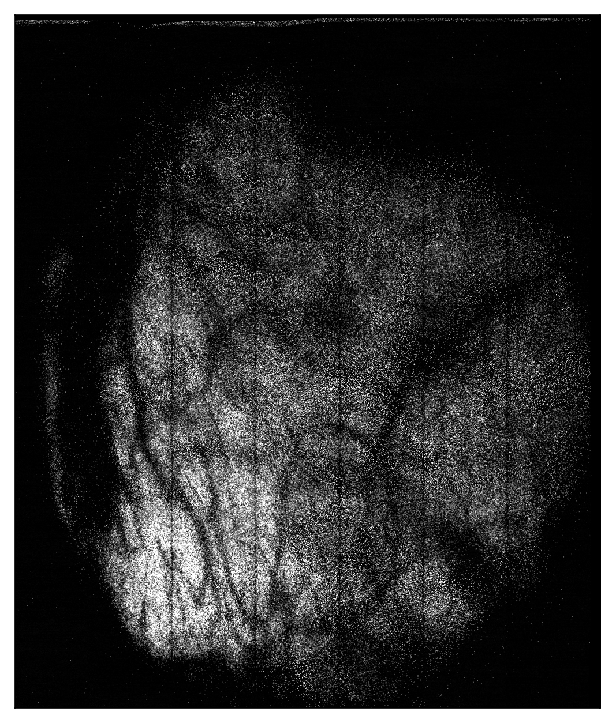

In [209]:
tfu.show_tif(mov_trf_cpu[3,5])


(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fac7ad0dac0>)

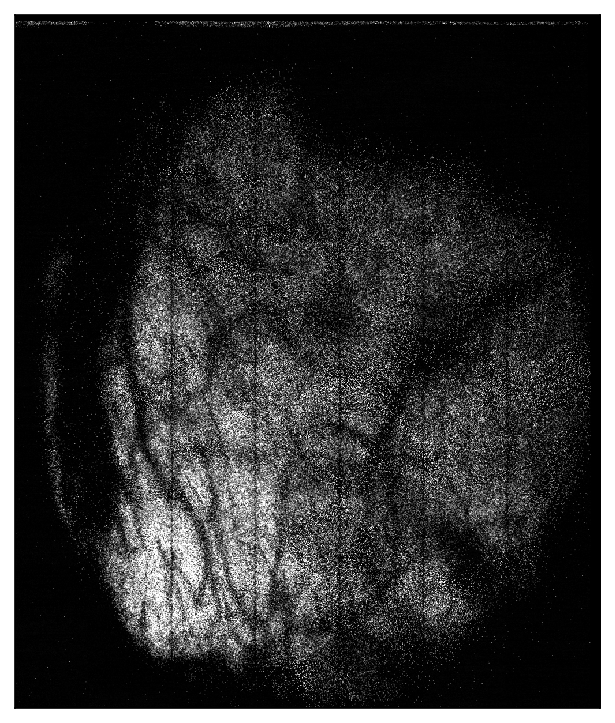

In [208]:
tfu.show_tif(mov_trf_cpu_fast[3,5])